In [37]:
import random,os,glob,time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torchvision

from torchinfo import summary
from torch import nn
from torchvision import transforms
from torch.utils.data import (Dataset, DataLoader)
from pathlib import Path
from PIL import Image
from tqdm.notebook import tqdm
from typing import Dict, List, Tuple
from scikitplot.metrics import plot_roc
import matplotlib.pyplot as plotter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, precision_recall_fscore_support,
    accuracy_score, top_k_accuracy_score, f1_score, 
    matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay
)


import warnings
warnings.filterwarnings("ignore")

In [38]:
class CFG:
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    NUM_DEVICES = torch.cuda.device_count()
    NUM_WORKERS = os.cpu_count()
    NUM_CLASSES = 2
    EPOCHS = 15 
    BATCH_SIZE = 32 
  #  BATCH_SIZE = 4
    LR = 0.001   #0.001
    APPLY_SHUFFLE = True
    SEED = 2024
    HEIGHT = 256
    WIDTH = 256
    CHANNELS = 3
    IMAGE_SIZE = (256, 256, 3)

In [39]:
TRAIN_PATH = Path("/kaggle/input/gender-recognizer/dataset")
IMAGE_PATH_LIST = list(TRAIN_PATH.glob("*/*.jpg"))
print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 1195


In [40]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,img_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = img_path
    labels[i] = img_path.parent.stem
    
df = pd.DataFrame({'image_path':images_path, 
                                  'label':labels})

df

image_path  label
0     /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN
1     /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN
2     /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN
3     /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN
4     /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN
...                                                 ...    ...
1190  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN
1191  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN
1192  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN
1193  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN
1194  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN

[1195 rows x 2 columns]

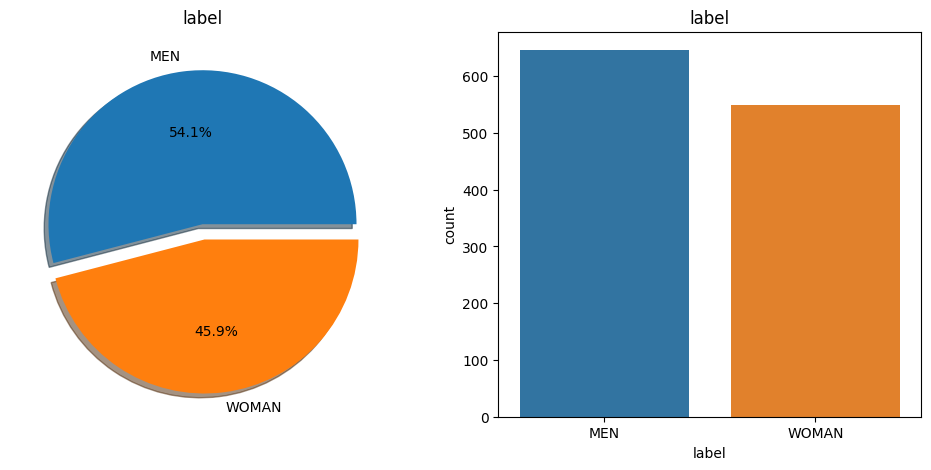

In [41]:
# Sort dataset_df by 'label' value counts
sorted_counts = df['label'].value_counts().sort_values(ascending=False)

# Create subplots
f, ax = plt.subplots(1, 2, figsize=(12, 5))

# Pie chart sorted by value counts
explode = [0] * len(sorted_counts)
explode[1] = 0.1  # Explode the second slice

sorted_counts.plot.pie(explode=explode, autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('label')
ax[0].set_ylabel('')

# Count plot sorted by value counts
sns.countplot(x=df['label'], order=sorted_counts.index, ax=ax[1])
ax[1].set_title('label')

plt.show()

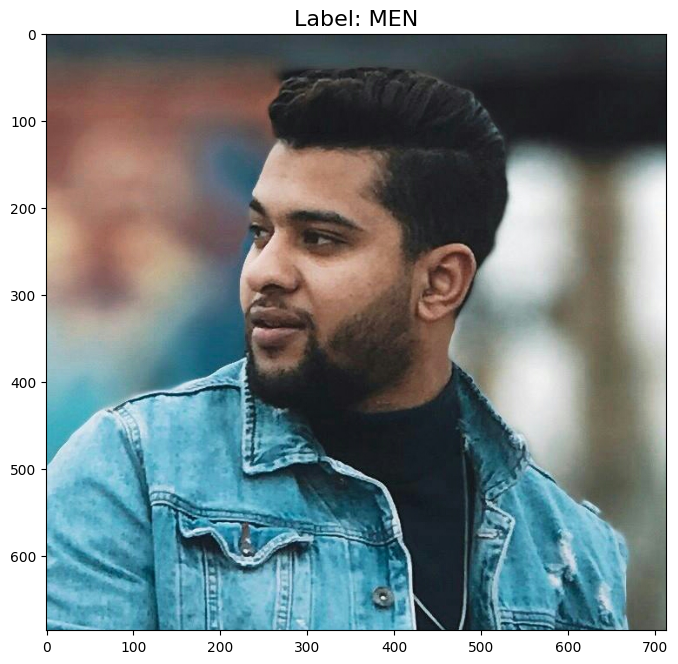

In [42]:
def _load(image_path, as_tensor=True):

    image = Image.open(image_path)
    
    if as_tensor:
        converter = transforms.ToTensor()
        return converter(image)
    else:
        return image


def view_sample(image, label, color_map='rgb', fig_size=(8, 10)):
    plt.figure(figsize=fig_size)
    
    if color_map=='rgb':
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color_map)
    
    plt.title(f'Label: {label}', fontsize=16)
    return


# Select random sample from train_df
idx = random.sample(df.index.to_list(), 1)[0]

# Load the random sample and label
sample_image, sample_label = _load(df.image_path[idx]), df.label[idx]

# View the random sample
view_sample(sample_image.permute(1, 2, 0), sample_label)

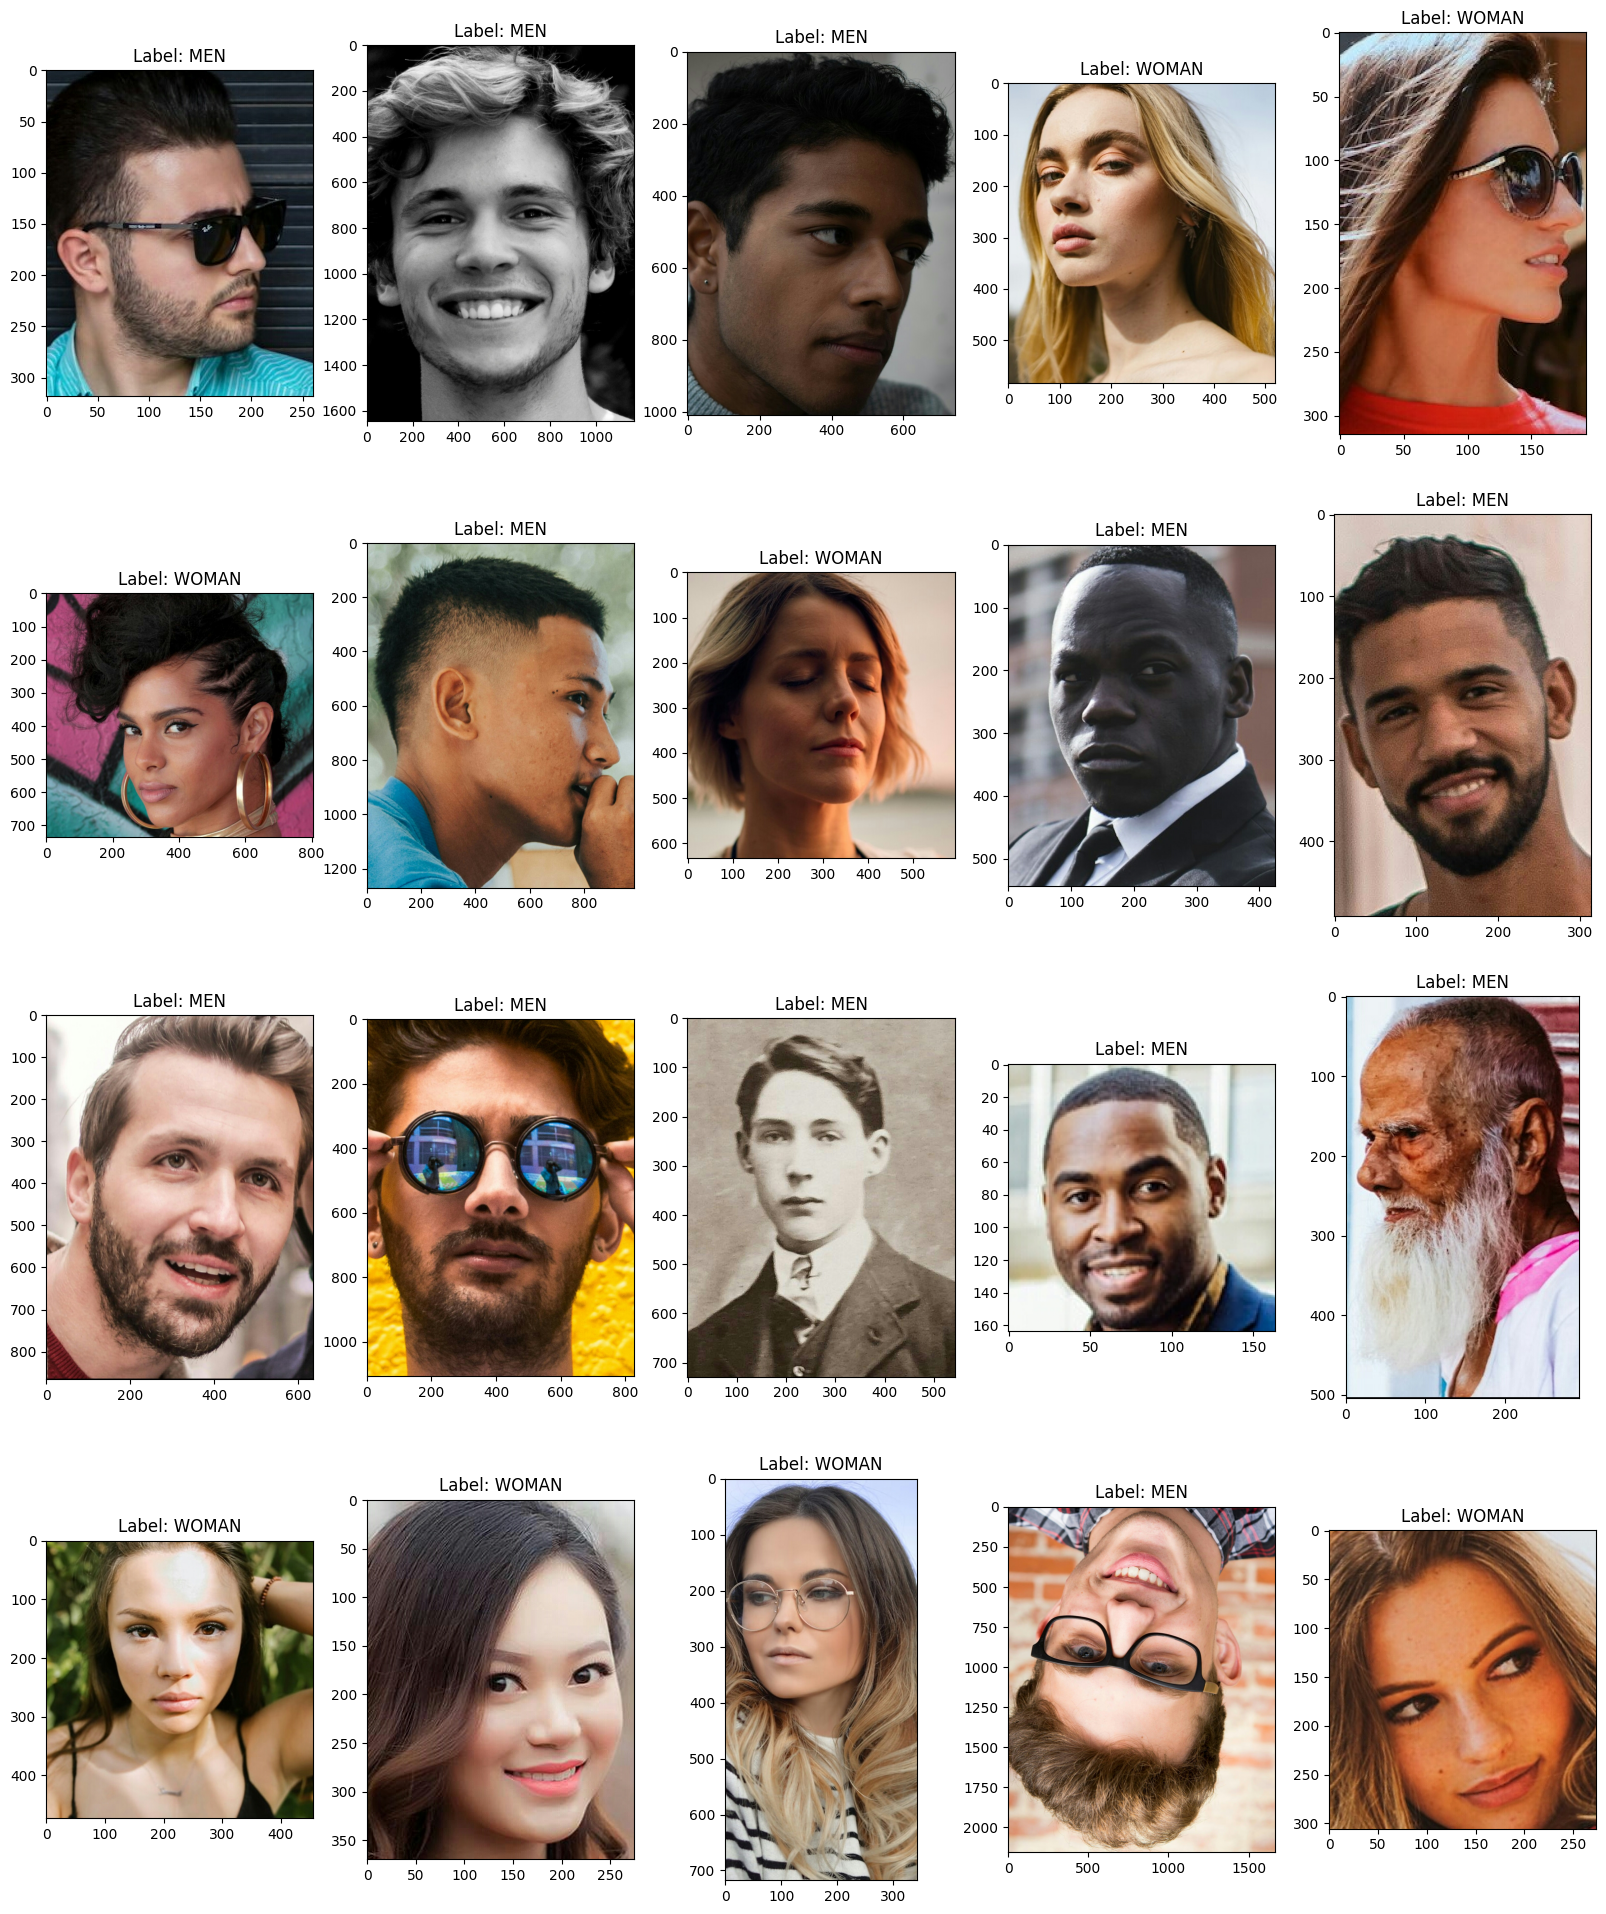

In [43]:
def view_mulitiple_samples(df, sample_loader, count=10, color_map='rgb', fig_size=(14, 10)):
    rows = count//5
    if count%5 > 0:
        rows +=1
    
    idx = random.sample(df.index.to_list(), count)    
    fig = plt.figure(figsize=fig_size)

    for column, _ in enumerate(idx):
        plt.subplot(rows, 5, column+1)
        plt.title(f'Label: {df.label[_]}')
        
        if color_map=='rgb':
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0))
        else:
            plt.imshow(sample_loader(df.image_path[_]).permute(1, 2, 0), cmap=color_map)
    
    return

view_mulitiple_samples(
       df, _load, 
    count=20, fig_size=(20, 24)  # View 20 random sample images
)

In [44]:
# split train data and temp data
# temp = valid + test 
train_split_idx, temp_split_idx, _, _ = (
    train_test_split(
        df.index, 
        df.label, 
        test_size=0.30,
        stratify=df.label,
        random_state=CFG.SEED
    )
)
train_df = df.iloc[train_split_idx].reset_index(drop=True)
temp_df = df.iloc[temp_split_idx].reset_index(drop=True)

# View shapes
train_df.shape, temp_df.shape

((836, 2), (359, 2))

In [45]:
# split valid data and test data
val_split_idx, test_split_idx, _, _ = (
    train_test_split(
        temp_df.index, 
        temp_df.label, 
        test_size=0.5,
        stratify=temp_df.label,
        random_state=CFG.SEED
    )
)
val_df = temp_df.iloc[val_split_idx].reset_index(drop=True)
test_df = temp_df.iloc[test_split_idx].reset_index(drop=True)

# View shapes
val_df.shape, test_df.shape

((179, 2), (180, 2))

In [46]:
# Calculate sample sizes
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

print(f'train samples count:\t\t{train_size}\t({(100 * train_size/total):.2f}%)')
print(f'validation samples count:\t{val_size}\t({(100 * val_size/total):.2f}%)')
print(f'test samples count:\t\t{test_size}\t({(100 * test_size/total):.2f}%)')
print('================================================')
print(f'Total:\t\t\t\t{total}\t({(100 * total/total):.2f}%)')

train samples count:		836	(69.96%)
validation samples count:	179	(14.98%)
test samples count:		180	(15.06%)
Total:				1195	(100.00%)


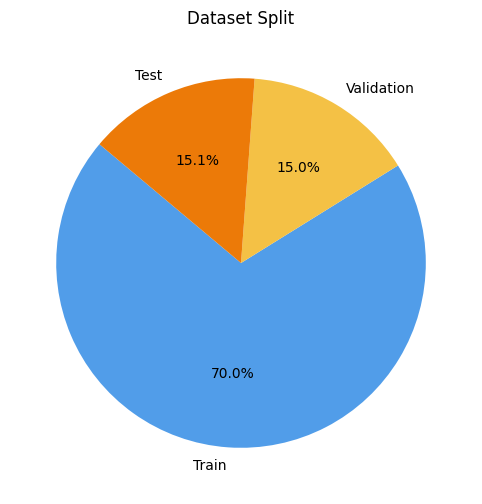

In [47]:
# Calculate sample sizes
train_size = len(train_df)
val_size = len(val_df)
test_size = len(test_df)
total = train_size + val_size + test_size

# Calculate percentages
train_percent = 100 * train_size / total
val_percent = 100 * val_size / total
test_percent = 100 * test_size / total

# Plotting
plt.figure(figsize=(10, 6))

# Pie chart
sizes = [train_size, val_size, test_size]
labels = ['Train', 'Validation', 'Test']
colors = ['#519DE9', '#F4C145', '#EC7A08']
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title('Dataset Split')

plt.show()

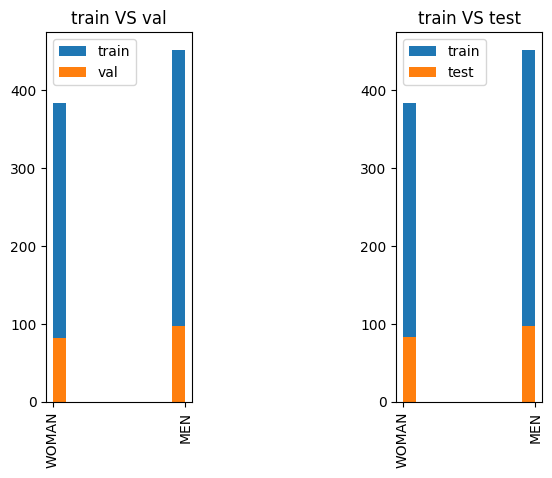

In [48]:
plt.subplot(1, 3, 1)
plt.hist(train_df["label"], label='train');
plt.hist(val_df["label"], label='val');
plt.legend();
plotter.xticks(rotation = 90);
plt.title('train VS val');

plt.subplot(1, 3, 3)
plt.hist(train_df["label"], label='train');
plt.hist(test_df["label"], label='test');
plt.legend();
plotter.xticks(rotation = 90);
plt.title('train VS test');

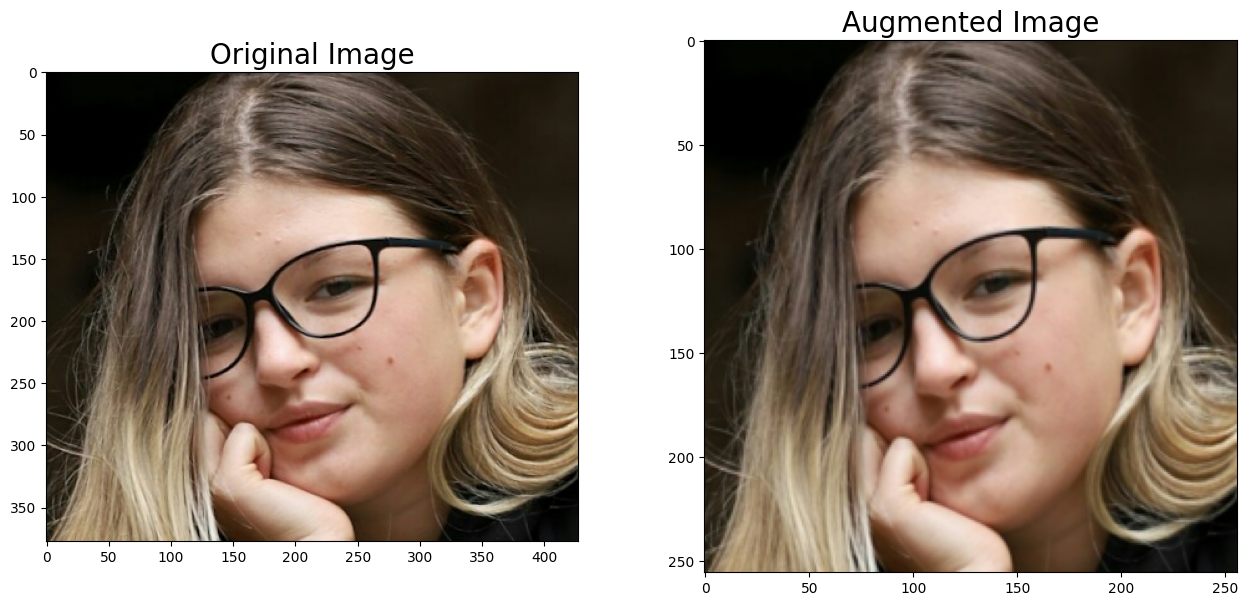

In [49]:
# Augment train data : is a technique used to expand training datasets by increasing data diversity.
train_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor()
])

# Only reshape test data
test_transforms = transforms.Compose([
    transforms.Resize((CFG.HEIGHT, CFG.WIDTH)),
    transforms.ToTensor()
])
# Select random sample from train_df
idx = random.sample(df.index.to_list(), 1)[0]

# Load the random sample and label
aug_image = _load(df.image_path[idx], as_tensor=False)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 10))

# Set the spacing between subplots
fig.tight_layout(pad=6.0)

# View Original Image
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(aug_image);

# View Augmented Image
ax2.set_title('Augmented Image', fontsize=20)
ax2.imshow(train_transforms(aug_image).permute(1, 2, 0));

In [50]:
class GRDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None) -> None:
        super().__init__()
        
        self.paths = df['image_path'].to_list()
        self.labels = df['label'].to_list()
        self.transform = transform
        
        self.classes = sorted(list(df['label'].unique()))
        self.class_to_idx = {cls_name: _ for _, cls_name in enumerate(self.classes)}
        
    def load_image(self, index:int) -> Image.Image:
        image_path = self.paths[index]
        return Image.open(image_path).convert('RGB')  
        
    def __len__(self) -> int:
        return self.paths.__len__()
    
    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        image = self.load_image(index)
        class_name = self.labels[index]
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(image), class_idx
        else:
            return image, class_idx


# Build train dataset
train_ds = GRDataset(train_df, transform=train_transforms)

# Build valid dataset
val_ds = GRDataset(val_df, transform=test_transforms)

# Build test dataset
test_ds = GRDataset(test_df, transform=test_transforms)
# Build train dataloader
train_loader = DataLoader(
    dataset=train_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=CFG.APPLY_SHUFFLE
)

# Build valid dataloader
val_loader = DataLoader(
    dataset=val_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=(not CFG.APPLY_SHUFFLE)
)

# Build test dataloader
test_loader = DataLoader(
    dataset=test_ds, 
    batch_size=CFG.BATCH_SIZE,
    num_workers=CFG.NUM_WORKERS,
    shuffle=(not CFG.APPLY_SHUFFLE)
)

In [51]:
def build_model(device: torch.device=CFG.NUM_CLASSES) -> nn.Module:
    # Set the manual seeds
    torch.manual_seed(CFG.SEED)
    torch.cuda.manual_seed(CFG.SEED)

    # Get model weights
    model_weights = (
        torchvision
        .models
        .EfficientNet_B0_Weights
        .DEFAULT
    )
    
    # Get model and push to device
    model = (
        torchvision.models.efficientnet_b0(
            weights=model_weights
        )
    ).to(device) 
    
    # Freeze Model Parameters
    for param in model.features.parameters():
        param.requires_grad = False
    
    # Define new classifier and push to the target device
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p=0.2, inplace=True), 
        nn.Linear(
            in_features=1280, out_features=CFG.NUM_CLASSES,bias=True
        )
    ).to(device)
    
    return model


In [52]:
# Define Loss Function
loss_fn = nn.CrossEntropyLoss(
    label_smoothing=0.1
)

# Define Optimizer : Adam
optimizer = torch.optim.Adam(
    efficientnet_B0.parameters(),
    lr=CFG.LR
)

In [53]:
def execute_epoch(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into training mode
    model.train()
    
    # Initialize train loss & accuracy
    train_loss, train_acc = 0, 0
    
    # Execute training loop over train dataloader
    for batch, (X, y) in enumerate(tqdm(dataloader)):
        # Load data onto target device
        X, y = X.to(device), y.to(device)
        
        # Feed-forward and compute metrics
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        
        # Reset Gradients & Backpropagate Loss
        optimizer.zero_grad()
        loss.backward()
        
        # Update Model Gradients
        optimizer.step()
        
        # Compute Batch Metrics
        predicted_class = torch.argmax(
            torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    
    return train_loss, train_acc

In [54]:
def evaluate(
    model:torch.nn.Module,
    dataloader:torch.utils.data.DataLoader,
    loss_fn:torch.nn.Module,
    device:torch.device) -> Tuple[float, float]:
    
    # Set model into eval mode
    model.eval()
    
    # Initialize eval loss & accuracy
    eval_loss, eval_acc = 0, 0
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            eval_loss += loss.item() 

            # Compute Batch Metrics
            predicted_class = torch.argmax(
                torch.softmax(y_pred, dim=1), dim=1)
            eval_acc += (predicted_class == y).sum().item() / len(y_pred)
        
    # Compute Step Metrics
    eval_loss = eval_loss / len(dataloader)
    eval_acc = eval_acc / len(dataloader)
    
    return eval_loss, eval_acc

In [55]:
def train(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    eval_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device) -> Dict[str, List]:
    
    # Initialize training session
    session = {
        'loss'          : [],
        'accuracy'      : [],
        'eval_loss'     : [],
        'eval_accuaracy': []
    }
    
    # Training loop
    for epoch in tqdm(range(epochs)):
        # Execute Epoch
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_acc = execute_epoch(
            model, 
            train_dataloader, 
            optimizer, 
            loss_fn, 
            device
        )
        
        # Evaluate Model
        eval_loss, eval_acc = evaluate(
            model, 
            eval_dataloader,
            loss_fn, 
            device
        )     
               
        
        # Log Epoch Metrics
        print(f'loss: {train_loss:.4f} - acc: {train_acc:.4f} - eval_loss: {eval_loss:.4f} - eval_acc: {eval_acc:.4f}')
        
        # Record Epoch Metrics
        session['loss'].append(train_loss)
        session['accuracy'].append(train_acc)
        session['eval_loss'].append(eval_loss)
        session['eval_accuaracy'].append(eval_acc)
        
        
    # Return Session Metrics
    return session

In [57]:
# Train the model 
print('Training EfficientNet Model')
print(f'Train on {len(train_df)} samples, validate on {len(val_df)} samples.')
print('----------------------------------')

session_config = {
    'model'               : efficientnet_B0,
    'train_dataloader'    : train_loader,
    'eval_dataloader'     : val_loader,
    'optimizer'           : optimizer,
    'loss_fn'             : loss_fn,
    'epochs'              : CFG.EPOCHS,
    'device'              : CFG.DEVICE
}

session_history = train(**session_config)

Training EfficientNet Model
Train on 836 samples, validate on 179 samples.
----------------------------------


  0%|          | 0/15 [00:00<?, ?it/s]


Epoch 1/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3622 - acc: 0.9097 - eval_loss: 0.3283 - eval_acc: 0.9391

Epoch 2/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3309 - acc: 0.9352 - eval_loss: 0.3171 - eval_acc: 0.9427

Epoch 3/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3095 - acc: 0.9444 - eval_loss: 0.3136 - eval_acc: 0.9427

Epoch 4/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3183 - acc: 0.9363 - eval_loss: 0.3108 - eval_acc: 0.9391

Epoch 5/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3249 - acc: 0.9375 - eval_loss: 0.3087 - eval_acc: 0.9444

Epoch 6/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3164 - acc: 0.9317 - eval_loss: 0.3030 - eval_acc: 0.9444

Epoch 7/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3362 - acc: 0.9363 - eval_loss: 0.3038 - eval_acc: 0.9531

Epoch 8/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3201 - acc: 0.9398 - eval_loss: 0.3106 - eval_acc: 0.9444

Epoch 9/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.2977 - acc: 0.9537 - eval_loss: 0.3019 - eval_acc: 0.9479

Epoch 10/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3071 - acc: 0.9398 - eval_loss: 0.3054 - eval_acc: 0.9444

Epoch 11/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3022 - acc: 0.9549 - eval_loss: 0.3030 - eval_acc: 0.9391

Epoch 12/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.2909 - acc: 0.9537 - eval_loss: 0.3020 - eval_acc: 0.9427

Epoch 13/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.2940 - acc: 0.9525 - eval_loss: 0.3116 - eval_acc: 0.9339

Epoch 14/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.2998 - acc: 0.9641 - eval_loss: 0.3042 - eval_acc: 0.9287

Epoch 15/15


  0%|          | 0/27 [00:00<?, ?it/s]

loss: 0.3038 - acc: 0.9630 - eval_loss: 0.3068 - eval_acc: 0.9339


In [58]:
def predict(
    model:nn.Module, 
    sample_loader:torch.utils.data.DataLoader,
    device:torch.device) -> np.ndarray:
    
    # Set model into eval mode
    model.eval()
    
    predictions = []
    
    # Active inferene context manager
    with torch.inference_mode():
        # Execute eval loop over dataloader
        for batch, (X, y) in enumerate(tqdm(sample_loader)):
            # Load data onto target device
            X, y = X.to(device), y.to(device)

            # Feed-forward and compute metrics
            y_pred = model(X) 

            # Compute Batch Metrics
            predicted_probs = torch.softmax(y_pred, dim=1).cpu().numpy()
            
            # Record prediction
            predictions.append(predicted_probs)
        
    return np.vstack(predictions)

In [59]:
test_probs = predict(efficientnet_B0, test_loader, CFG.DEVICE)
test_preds = np.argmax(test_probs, axis=1)
test_preds

  0%|          | 0/6 [00:00<?, ?it/s]

array([1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1])

In [60]:
def plot_training_curves(history):
    
    loss = np.array(history['loss'])
    val_loss = np.array(history['eval_loss'])

    accuracy = np.array(history['accuracy'])
    val_accuracy = np.array(history['eval_accuaracy'])

    epochs = range(len(history['loss']))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='o')
    ax1.plot(epochs, val_loss, label='eval_loss', marker='o')
    
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)

    ax1.set_title('Loss (Lower Means Better)', fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.legend()

    # Plot accuracy
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='o')
    ax2.plot(epochs, val_accuracy, label='eval_accuracy', marker='o')
    
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)

    ax2.set_title('Accuracy (Higher Means Better)', fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.legend();
    
    sns.despine();
    
    return
# Convert history dict to DataFrame
session_history_df = pd.DataFrame(session_history)
session_history_df

loss  accuracy  eval_loss  eval_accuaracy
0   0.362162  0.909722   0.328348        0.939145
1   0.330867  0.935185   0.317079        0.942708
2   0.309544  0.944444   0.313562        0.942708
3   0.318284  0.936343   0.310752        0.939145
4   0.324862  0.937500   0.308732        0.944353
5   0.316389  0.931713   0.302981        0.944353
6   0.336235  0.936343   0.303763        0.953125
7   0.320050  0.939815   0.310603        0.944353
8   0.297654  0.953704   0.301855        0.947917
9   0.307086  0.939815   0.305425        0.944353
10  0.302183  0.954861   0.302991        0.939145
11  0.290940  0.953704   0.301993        0.942708
12  0.294030  0.952546   0.311604        0.933936
13  0.299783  0.964120   0.304173        0.928728
14  0.303804  0.962963   0.306832        0.933936

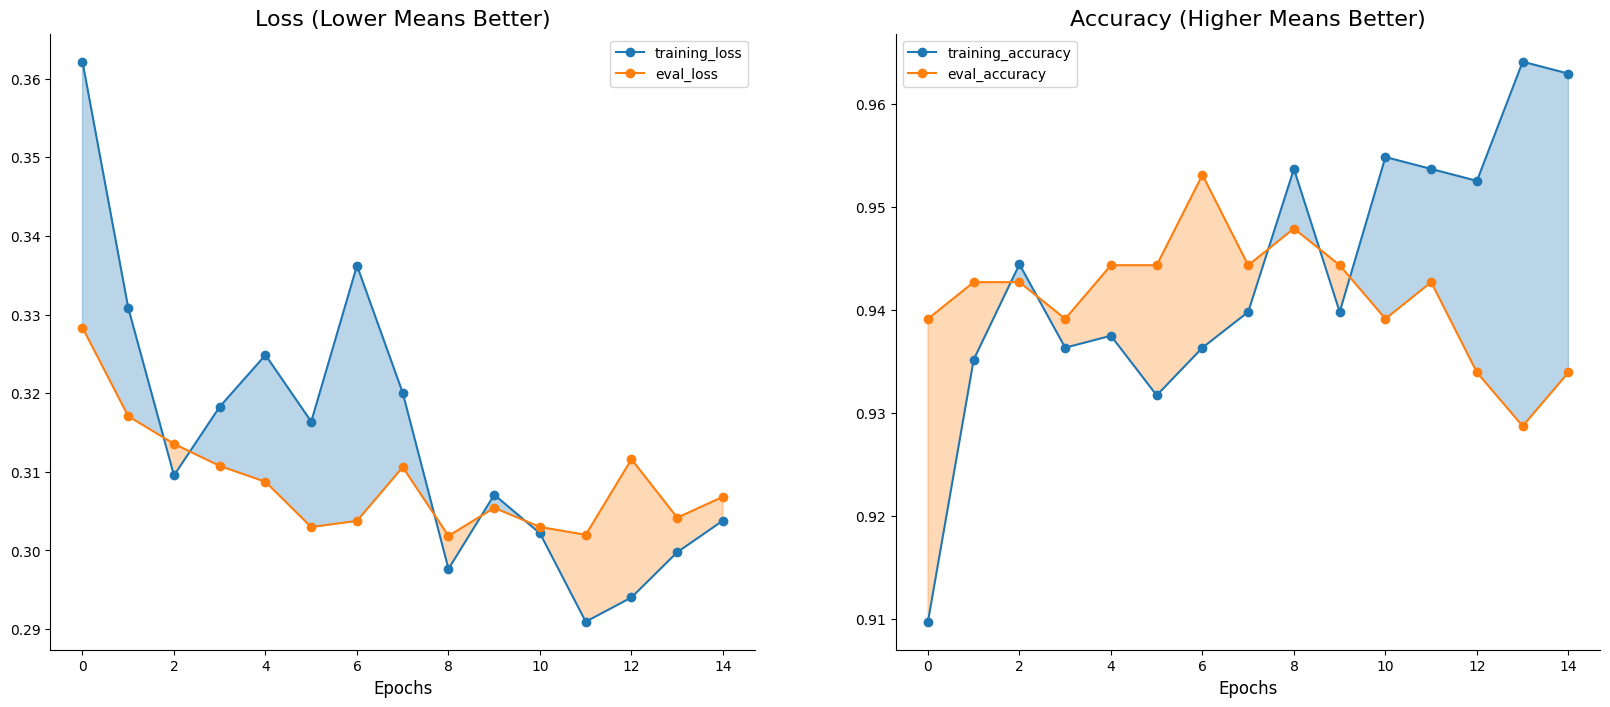

In [61]:
# Plot EfficientNet session training history 
plot_training_curves(session_history)

Accuracy is: 94.444%


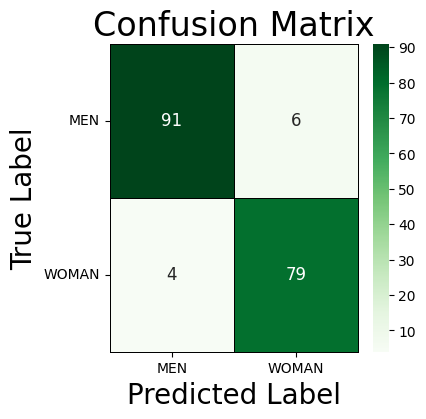

In [62]:
def plot_confusion_matrix(y_true, y_pred, classes='auto', figsize=(10, 10), text_size=12): 
    # Generate confusion matrix 
    cm = confusion_matrix(y_true, y_pred)
    
    # Set plot size
    plt.figure(figsize=figsize)

    # Create confusion matrix heatmap
    disp = sns.heatmap(
        cm, annot=True, cmap='Greens',
        annot_kws={"size": text_size}, fmt='g',
        linewidths=0.5, linecolor='black', clip_on=False,
        xticklabels=classes, yticklabels=classes)
    
    # Set title and axis labels
    disp.set_title('Confusion Matrix', fontsize=24)
    disp.set_xlabel('Predicted Label', fontsize=20) 
    disp.set_ylabel('True Label', fontsize=20)
    plt.yticks(rotation=0) 

    # Plot confusion matrix
    plt.show()
    
    return
test_labels = [*map(test_ds.class_to_idx.get, test_ds.labels)]
accuracy = accuracy_score(test_labels, test_preds)
print("Accuracy is: {0:.3f}%".format(accuracy * 100))

plot_confusion_matrix(
    test_labels, 
    test_preds, 
    figsize=(4, 4),  
    classes=test_ds.classes)

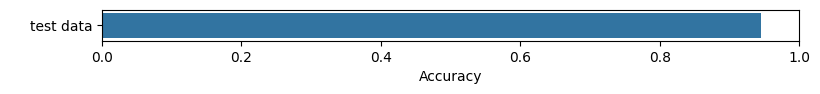

In [63]:
#DataFrame
Visualization_models = [('test data', accuracy)]                                          
Visualization_predict = pd.DataFrame(data = Visualization_models, columns=[' ', 'Accuracy'])

#Visualization
f, axe = plt.subplots(1,1, figsize=(9,0.4))
Visualization_predict.sort_values(by=['Accuracy'], ascending=False, inplace=True)
sns.barplot(x='Accuracy', y=' ',  data = Visualization_predict, ax = axe)
axe.set_xlabel('Accuracy', size=10)
axe.set_ylabel(' ', size=10)
axe.set_xlim(0,1.0)
plt.show()

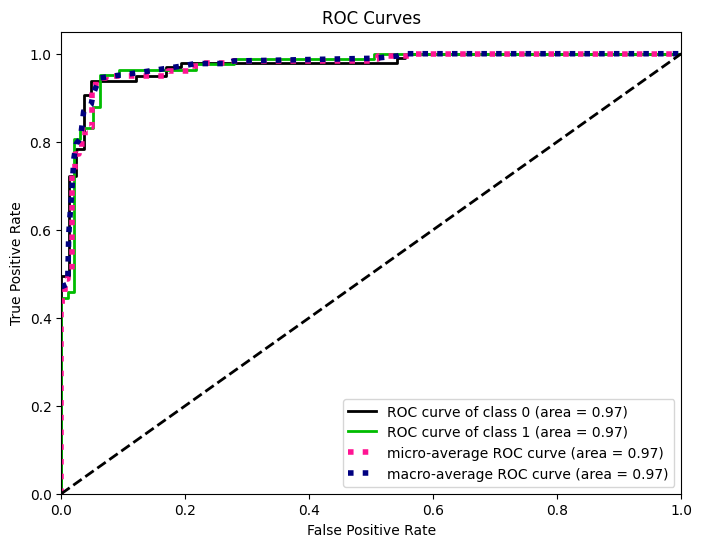

In [64]:
plot_roc(
    test_labels, 
    test_probs, 
    figsize=(8, 6), title_fontsize='large'
);

In [65]:
print(
    classification_report(
        test_labels, 
        test_preds, 
        target_names=test_ds.classes
    )
)

              precision    recall  f1-score   support

         MEN       0.96      0.94      0.95        97
       WOMAN       0.93      0.95      0.94        83

    accuracy                           0.94       180
   macro avg       0.94      0.94      0.94       180
weighted avg       0.94      0.94      0.94       180



In [66]:
def generate_performance_scores(y_true, y_pred, y_probabilities):
    
    model_accuracy = accuracy_score(y_true, y_pred)
    model_precision, model_recall, model_f1, _ = (
        precision_recall_fscore_support(
            y_true, y_pred, average="weighted"
        )
    )    
    model_matthews_corrcoef = matthews_corrcoef(y_true, y_pred)
    
    print('=============================================')
    print(f'\nPerformance Metrics:\n')
    print('=============================================')
    print(f'accuracy_score:\t\t{model_accuracy:.4f}\n')
    print('_____________________________________________')
    print(f'precision_score:\t{model_precision:.4f}\n')
    print('_____________________________________________')
    print(f'recall_score:\t\t{model_recall:.4f}\n')
    print('_____________________________________________')
    print(f'f1_score:\t\t{model_f1:.4f}\n')
    print('_____________________________________________')
    print(f'matthews_corrcoef:\t{model_matthews_corrcoef:.4f}\n')
    print('=============================================')
    
    preformance_scores = {
        'accuracy_score'       : model_accuracy,
        'precision_score'      : model_precision,
        'recall_score'         : model_recall,
        'f1_score'             : model_f1,
        'matthews_corrcoef'    : model_matthews_corrcoef
    }
    return preformance_scores

In [67]:
# Generate EfficieNet model performance scores
model_performance = generate_performance_scores(
    test_labels,
    test_preds, 
    test_probs
)


Performance Metrics:

accuracy_score:		0.9444

_____________________________________________
precision_score:	0.9448

_____________________________________________
recall_score:		0.9444

_____________________________________________
f1_score:		0.9445

_____________________________________________
matthews_corrcoef:	0.8886



In [68]:
results_df0 = pd.DataFrame({
    'image_path'       : test_ds.paths,
    'label'            : test_ds.labels,
    'label_encoded'    : test_labels,
    'model_prediction' : test_preds,
})

submission0=results_df0

submission0.to_csv('results_df0.csv', index=False)
submission0

image_path  label  label_encoded  \
0    /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN              1   
1    /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN              1   
2    /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN              0   
3    /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN              0   
4    /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN              0   
..                                                 ...    ...            ...   
175  /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN              0   
176  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN              1   
177  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN              1   
178  /kaggle/input/gender-recognizer/dataset/MEN/20...    MEN              0   
179  /kaggle/input/gender-recognizer/dataset/WOMAN/...  WOMAN              1   

     model_prediction  
0                   1  
1                   1  
2                   0  
3                   0  
4                   0  
..                ...  
175                 0  
176                 1  
177                 1  
178                 0  
179                 1  

[180 rows x 4 columns]